##### Possible Parameters:
- starting line * 
    - intelligent way to pick this slope?

- number of iterations *

- starting PT on the starting line (& thus subsequent lines)
    - intelligent way to pick the starting pt?

In [219]:
import shapely
from shapely import geometry
import math
shapely.__file__
import fiona # need to install from src in order for buffering to work. see: https://github.com/geoplex/elasticsearch-spatial/issues/1
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../alg')
import distance_buffer as db


In [220]:
reload(db)

<module 'distance_buffer' from '../../../alg/distance_buffer.pyc'>

In [221]:
import numpy as np

In [68]:
def gen_rand_pt(lo, hi):
    return ((lo - hi) * np.random.random() + hi)

In [351]:
# Note : this method will just pick the first rand pt found in the region
def gen_rand_pt_on_line(pt1, pt2, vec, region):
    pt = []
    mag = db.eucdist(pt1[0], pt1[1], pt2[0], pt2[1])
    randdist = gen_rand_pt(0, mag[0])
    randptp = pt1 + randdist*vec
    randptn = pt1 - randdist*vec
    randptp2 = pt2 + randdist*vec
    randptn2 = pt2 - randdist*vec

    if region.contains(geometry.Point(randptp)):
        pt = randptp
    elif region.contains(geometry.Point(randptn)):
        pt = randptn
    elif region.contains(geometry.Point(randptp2)):
        pt = randptp2
    elif region.contains(geometry.Point(randptn2)):
        pt = randptn2
    else:
        print "contains none...."
    #randptn = pt1 - randdist*vec
    #if 
    return pt

In [357]:
def gen_starting_line(bounds):
    # randomly pick 2 pts in area then get unit vector of that line
    pt1 = (gen_rand_pt(bounds[0],bounds[2]),gen_rand_pt(bounds[1],bounds[3]))
    pt2 = (gen_rand_pt(bounds[0],bounds[2]),gen_rand_pt(bounds[1],bounds[3]))
    # this switch doesnt really make a difference
    temp = pt2
    pt2 = np.array(pt1)
    pt1 = np.array(temp)
    v = pt2 - pt1
    line = v/np.linalg.norm(v)
    # TODO : vvv change this to a while loop
    #line = []
    #if not ((pt1[0]==pt2[0]) and (pt1[1]==pt2[1])):
    #    v = pt2 - pt1
    #    line = v / np.linalg.norm(v)
    #else:
    #    line = gen_starting_line(bounds)
    return line, pt1,pt2
    

In [410]:
def gen_cand_pts_on_line(poly, linevec, startpt, r):
    #main algorithm, start from the randomly generated intersecting line & then 
    # keeps track of running missed pts; stop once we get to a thresh
    nummissedpts = 0
    pt = startpt
    candpts = []
    candpts.append(startpt)
    optdist = math.sqrt(3)*r
    
    #positive direction loop
    while nummissedpts < 100:
        temppt = pt + optdist*linevec
        pt = temppt
        area = (region.intersection(geometry.Point(pt).buffer(r))).area
        #if poly.contains(geometry.Point(temppt)):
        if area > 0.0:
            candpts.append(temppt)
            nummissedpts = 0
        else:
            nummissedpts+=1
            
            
    nummissedpts = 0
    pt = startpt
    while nummissedpts < 100:
        temppt = pt - optdist*linevec
        pt = temppt
        area = (region.intersection(geometry.Point(pt).buffer(r))).area
        #if poly.contains(geometry.Point(temppt)):
        if area > 0.0:
            candpts.append(temppt)
            nummissedpts = 0
        else:
            nummissedpts+=1

   
    return candpts
    

In [428]:
def gen_cand_pts(poly, startvec, startpt, r):
    nummissedlines = 0
    candpts = []
    nextstpt = startpt
    
    #positive direction loop
    while nummissedlines < 100:
        temppts = gen_cand_pts_on_line(poly, startvec, nextstpt, r)
        if len(temppts) > 1:
            candpts.append(temppts)
            nextstpt = gen_next_line_startpt(nextstpt, startvec, r)
            nummissedlines=0
        else:
            nummissedlines+=1
            
    nummissedlines=0
    nextstpt=startpt
    while nummissedlines < 100:
        temppts = gen_cand_pts_on_line(poly, startvec, nextstpt, r)
        if len(temppts) > 1:
            candpts.append(temppts)
            nextstpt = gen_next_line_startpt(nextstpt, startvec, -1*r)
            nummissedlines=0
        else:
            nummissedlines+=1     
    return candpts
            

In [398]:
def gen_next_line_startpt(startpt, linevec, r):
    perpvec = [-linevec[1], linevec[0]]
    perpdist = (1.5)*r
    pardist = (math.sqrt(3)/2.0)*r
    temppt = startpt + perpdist*np.array(perpvec)
    newstartpt = temppt + pardist*linevec
    return newstartpt

In [339]:
# line[0] is starting pt, line[1] endpt; poly is a ring
def intersect_line_region(pt1,linevec, poly):
    
    intpt = []
    i = 1
    while len(intpt) < 2:
    #    # the line is a unit vector, get it long enough to make sure it intersects before we return the pt
        temp1 = pt1+ (100000.0*i)*linevec
        temp2 = pt1 - (100000.0*i)*linevec
        newline = geometry.LineString([temp1,temp2])
        intpt = newline.intersection(poly)
        i+=1
    
    return geometry.LineString(intpt)

In [30]:
def analyze_coverage(origpoly, candpts, r):
    
    
    return results
    

In [31]:
# Polygon to be covered, num of iterations to run algorithm, r = coverage radius
def marching_army(poly, numiter, r): #should there be some kind of variance parameter?
    
    # candptset[x] contains the candpts found for that in iter x; likewise for results[x]
    candptsets = []
    results = []
    
    for i in range(0, numiter):
        bds = poly.bounds
        line = gen_starting_line(bds)
        candptsets.append(gen_cand_pts(poly, startline, r))
        results.append(analyze_coverage(poly, candptsets[i], r))
    
    return candptsets, results

### Read in the shapefile and get the polygon that we're going to work with

In [35]:
shp = fiona.open("../../../data/YukonAlaska/YukonRegionCRS.shp")
l = iter(shp) # get the list of geoms from the shapefile 
first = next(l)
shp_geom = shapely.geometry.shape(first['geometry'])

# This is a sufficiently irregular shape so we will go with this one
region = shp_geom
print len(region.exterior.coords)
print len(region.interiors)
print region.area
region
print region.bounds

183
0
4918771.66688
(-631535.6236662696, 1321572.2678891697, -630132.1088717761, 1327921.5599169973)


### Run marching army algorithm on the polygon

In [34]:
candptsets, coverresults = marching_army(region, 1000)

4


TypeError: 'NoneType' object is not iterable

### START here

In [340]:
bounds = region.bounds
start_line, pt1,pt2 = gen_starting_line(bounds)
print start_line
print pt1,pt2


[ 0.03962154  0.99921476]
[ -631043.50761459  1322134.72776422] [ -630854.11745302  1326910.95403674]


In [341]:
intpt = intersect_line_region(pt1, start_line, region.exterior)
print intpt

LINESTRING (-631065.679734361 1321575.569568916, -631057.7910396676 1321774.514384942, -631047.1490753026 1322042.893847576, -630855.6597971963 1326872.05769333, -630844.1881165965 1327161.361751238, -630843.7558990323 1327172.261836378, -630836.6100758255 1327352.472192904, -630835.7924213248 1327373.092603573, -630831.9048865301 1327471.132257098, -630816.7217635473 1327854.035097923)


In [355]:
randpts = gen_rand_pt_on_line(pt1, pt2, start_line, region)
print randpts

[ -630912.50646191  1325438.44292009]


In [358]:
print start_line

[ 0.03962154  0.99921476]


In [411]:
candpts1 = gen_cand_pts_on_line(region, start_line,randpts, 100.0)


In [412]:
nextstpt = gen_next_line_startpt(randpts, start_line, 100.0)

In [413]:
candpts2 = gen_cand_pts_on_line(region, start_line, nextstpt, 100.0)

In [429]:
candptsalltry1 = gen_cand_pts(region, start_line, randpts, 100.0)


In [430]:
print len(candptsalltry1)

11


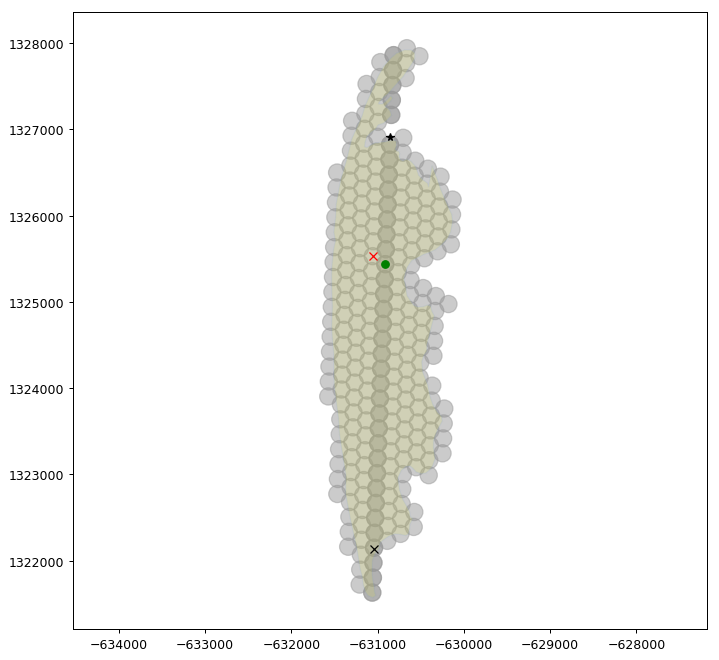

In [431]:
ax, fig = db.plot_fig(region)
#db.plot_line(ax, intpt.coords,ls='-',color='red',zorder=2)
#temp = zip(*randpts)
ax.plot(pt1[0], pt1[1], 'x', color="black")
ax.plot(pt2[0], pt2[1], '*', color="black")
ax.plot(nextstpt[0], nextstpt[1], 'x', color='red')
#db.plot_radii(ax, zip(*candpts1),100.0)
tcandpts1 = zip(*candpts1)
tcandpts2 = zip(*candpts2)
#ax.plot(tcandpts1[0], tcandpts1[1], 'o',ms=0.2, color='pink')
#db.plot_radii(ax, candpts1, 100.0, alpha=0.5)
#db.plot_radii(ax, candpts2, 100.0, alpha=0.5)
for i in range(0, len(candptsalltry1)):
    db.plot_radii(ax, candptsalltry1[i], 100.0, alpha=0.5)
ax.plot(randpts[0], randpts[1], 'o', color='green')
pyplot.show()

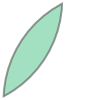

In [416]:
(geometry.Point(candpts1[0]).buffer(100.0)).intersection(geometry.Point(candpts2[0]).buffer(100.0))

In [66]:
p =np.array([1,2])
print p

[1 2]


In [224]:
bounds = region.bounds
pt1 = np.array([gen_rand_pt(bounds[0],bounds[2]), gen_rand_pt(bounds[1],bounds[3])])
pt2 = np.array([gen_rand_pt(bounds[0], bounds[2]), gen_rand_pt(bounds[1], bounds[3])])
line = []
if not ((pt1[0]==pt2[0]) and (pt1[1]==pt[1])):
    v = pt2 - pt1
    line = v / np.linalg.norm(v)

    print line
print bounds
print pt1, pt2

[ 0.26967216 -0.96295219]
(-631535.6236662696, 1321572.2678891697, -630132.1088717761, 1327921.5599169973)
[ -630988.49830285  1326571.68047753] [ -630542.89201829  1324980.4982268 ]


In [134]:
vecpt1 = line*1000000.0
vecpt2 = line*-1000000.0

vecline = geometry.LineString([vecpt1, vecpt2])
intpt2 = vecline.intersection(region.exterior)

In [135]:
print vecline
print intpt2

LINESTRING (342248.505310455 -939609.4723941215, -342248.505310455 939609.4723941215)
GEOMETRYCOLLECTION EMPTY


In [136]:
linepts = geometry.LineString([pt1,pt2])
intpt = linepts.intersection(region.exterior)
print intpt

GEOMETRYCOLLECTION EMPTY


In [137]:
print linepts
print intpt


LINESTRING (-631290.9326336206 1324783.839110376, -630727.1346371475 1323235.987389234)
GEOMETRYCOLLECTION EMPTY


In [141]:
temp1 = pt1+ 100000.0*line
temp2 = pt1 - 100000.0*line
try3 = geometry.LineString([temp1,temp2])
intpt3 = try3.intersection(region.exterior)
print try3
print intpt3

LINESTRING (-597066.0821025751 1230822.891870964, -665515.783164666 1418744.786349788)
MULTIPOINT (-631528.5002035924 1325436.05741262, -630674.6334533931 1323091.850574019)


In [214]:
# convert from multipoint to a linestring for plotting
print list(intpt3.geoms)
linetry3 = geometry.LineString(intpt3)

[<shapely.geometry.point.Point object at 0x10da68050>, <shapely.geometry.point.Point object at 0x10d1ac110>]


In [163]:
print linetry3

LINESTRING (-631528.5002035924 1325436.05741262, -630674.6334533931 1323091.850574019)


## Plot the figure

In [210]:
ax, fig = db.plot_fig(region)

[(-631528.5002035924, 1325436.0574126197), (-630674.6334533931, 1323091.8505740194)]


In [212]:
db.plot_line(ax, linetry3.coords,ls='-',color='red',zorder=2)

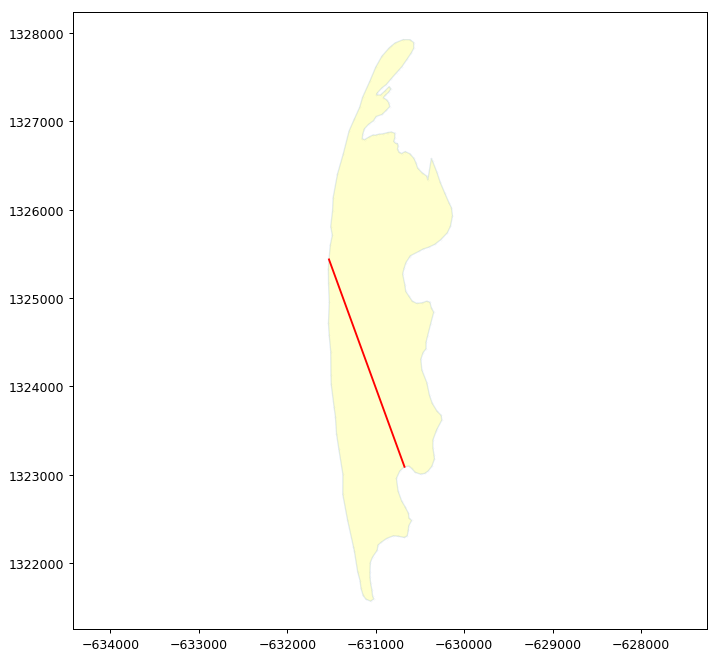

In [213]:
pyplot.show()